## Import the necessary library


In [1]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
env = UnityEnvironment(file_name='./Crawler_Windows_x86_64/Crawler.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


### Method to plot the progress of the agent's score

In [3]:
def plot_result(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## Validation method
The noise has to be deactivated before the validation. This method is being used to assess the performance of the agent after every episode of training

In [4]:
def validate(agent, max_t, train_mode=True):
    env_info = env.reset(train_mode=train_mode)[brain_name]
    states = env_info.vector_observations
    scores_one_episode = np.zeros(states.shape[0])
    for t in range(max_t):
        actions, _, _ = agent.act(states)                        # select an action (for each agent)
        env_info = env.step(np.clip(actions, -1, 1))[brain_name]   # send all actions to the environment
        next_states = env_info.vector_observations               # get next state (for each agent)
        rewards = env_info.rewards                               # get reward (for each agent)
        dones = env_info.local_done                              # see if episode finished
        scores_one_episode += env_info.rewards                   # update the score (for each agent)
        states = next_states                                     # roll over states to next time step
        if np.any(dones):                                        # exit loop if episode finished
            break
    return scores_one_episode

## Training method
The main loop of the training can be found here

In [5]:
def train(agent, n_episodes=500, max_t=500, train_mode=True):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(states.shape[0])
        trajectories_states, trajectories_actions, trajectories_log_probs, trajectories_values, \
        trajectories_rewards, trajectories_next_states, trajectories_dones = [],[],[],[],[],[],[]
        
        for t in range(max_t):
            actions, log_probs, values = agent.act(states)
            env_info = env.step(np.clip(actions, -1, 1))[brain_name] # send all actions to the environment
            next_states = env_info.vector_observations               # get next state (for each agent)
            rewards = env_info.rewards                               # get reward (for each agent)
            dones = env_info.local_done                              # see if episode finished
            scores_one_episode += rewards
            trajectories_states.append(states)
            trajectories_actions.append(actions)
            trajectories_log_probs.append(log_probs)
            trajectories_values.append(values)
            trajectories_rewards.append(rewards)
            trajectories_next_states.append(next_states)
            trajectories_dones.append(dones)
            states = next_states                                     # roll over states to next time step
            if np.any(dones):                                        # exit loop if episode finished
                break
#                 env_info = env.reset(train_mode=train_mode)[brain_name]
#                 states = env_info.vector_observations 
  
        agent.learn(trajectories_states, trajectories_actions, trajectories_log_probs, trajectories_values, 
        trajectories_rewards, trajectories_next_states, trajectories_dones)
        score = np.average(scores_one_episode)
        scores.append(score)
        scores_window.append(score)
        mean_100 = np.mean(scores_window)
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tMin Score: {:.3f}\tMax Score: {:.3f}'.format(i_episode, mean_100, 
                                                                                                     np.min(np.array(scores_window)[-50:]),
                                                                                                     np.max(np.array(scores_window)[-50:])))
            agent.save("ppo_" + str(i_episode) + ".pth")
        if len(scores_window) >= 100 and np.mean(scores_window)>=2000:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, mean_100))
            agent.save("ppo_final.pth")
            break
    return scores

In [6]:
from agents.ppo import PPO
from agents.model_ppo import Gaussian
import random
import torch.nn.functional as F

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
states = env_info.vector_observations
action_size = brain.vector_action_space_size
network = Gaussian(states.shape[1], action_size, activation=F.leaky_relu).to(device)
agent = PPO(network, device)

In [10]:
agent.save("random.pth")
agent.LR=5e-4
agent.GRADIENT_CLIP=5
agent.EPOCHS=8
agent.BATCH_SIZE=64
agent.GAMMA=0.99
agent.GAE_TAU=0.95
agent.CLIP_EPSILON=0.2
agent.C1 = 0.5
agent.C2 = 1
scores = train(agent, n_episodes=60000, max_t=1010, train_mode=True)
plot_result(scores)

Episode 50	Average Score: 46.698	Min Score: 0.397	Max Score: 78.606
Episode 100	Average Score: 73.600	Min Score: 0.112	Max Score: 179.478
Episode 150	Average Score: 118.354	Min Score: 6.229	Max Score: 264.026
Episode 200	Average Score: 114.404	Min Score: 0.778	Max Score: 290.086
Episode 250	Average Score: 88.693	Min Score: 0.870	Max Score: 305.089
Episode 300	Average Score: 70.523	Min Score: 0.838	Max Score: 195.494
Episode 350	Average Score: 51.679	Min Score: 1.059	Max Score: 230.887
Episode 400	Average Score: 53.190	Min Score: 0.829	Max Score: 346.898
Episode 450	Average Score: 49.736	Min Score: 0.260	Max Score: 172.754
Episode 500	Average Score: 42.819	Min Score: 0.891	Max Score: 173.815
Episode 550	Average Score: 44.934	Min Score: 1.074	Max Score: 280.598
Episode 600	Average Score: 42.005	Min Score: 0.875	Max Score: 242.638
Episode 650	Average Score: 43.491	Min Score: 0.822	Max Score: 144.719
Episode 700	Average Score: 50.511	Min Score: 1.100	Max Score: 180.107
Episode 750	Average 

Episode 5850	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 5900	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 5950	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 6000	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 6050	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 6100	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 6150	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 6200	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 6250	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 6300	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 6350	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 6400	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 6450	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 6500	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episod

Episode 11600	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 11650	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 11700	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 11750	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 11800	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 11850	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 11900	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 11950	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 12000	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 12050	Average Score: -0.516	Min Score: -0.516	Max Score: -0.515
Episode 12100	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 12150	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 12200	Average Score: -0.516	Min Score: -0.516	Max Score: -0.516
Episode 12250	Average Score: -0.516	Min Score: -0.516	Max Score:

KeyboardInterrupt: 

## Continue the training

Episode 50	Average Score: 31.152	Min Score: 8.062	Max Score: 65.613
Episode 100	Average Score: 31.672	Min Score: 8.736	Max Score: 90.345
Episode 150	Average Score: 30.239	Min Score: 9.562	Max Score: 103.163
Episode 200	Average Score: 31.002	Min Score: 9.219	Max Score: 96.207
Episode 250	Average Score: 33.132	Min Score: 8.962	Max Score: 71.069
Episode 300	Average Score: 31.888	Min Score: 10.811	Max Score: 61.096
Episode 350	Average Score: 32.415	Min Score: 9.826	Max Score: 70.503
Episode 400	Average Score: 33.636	Min Score: 7.973	Max Score: 83.119
Episode 450	Average Score: 34.384	Min Score: 7.371	Max Score: 93.747
Episode 500	Average Score: 33.370	Min Score: 7.058	Max Score: 107.699
Episode 550	Average Score: 29.311	Min Score: 9.437	Max Score: 71.811
Episode 600	Average Score: 27.014	Min Score: 8.034	Max Score: 69.927
Episode 650	Average Score: 26.966	Min Score: 8.522	Max Score: 62.864
Episode 700	Average Score: 26.545	Min Score: 8.859	Max Score: 68.001
Episode 750	Average Score: 28.54

Episode 5850	Average Score: 93.715	Min Score: 14.972	Max Score: 318.419
Episode 5900	Average Score: 85.636	Min Score: 11.334	Max Score: 181.878
Episode 5950	Average Score: 72.303	Min Score: 12.865	Max Score: 301.790
Episode 6000	Average Score: 71.677	Min Score: 8.073	Max Score: 219.240
Episode 6050	Average Score: 87.559	Min Score: 13.472	Max Score: 472.845
Episode 6100	Average Score: 101.284	Min Score: 15.391	Max Score: 317.202
Episode 6150	Average Score: 98.709	Min Score: 14.248	Max Score: 477.482
Episode 6200	Average Score: 96.162	Min Score: 12.871	Max Score: 244.481
Episode 6250	Average Score: 91.738	Min Score: 16.600	Max Score: 267.323
Episode 6300	Average Score: 99.104	Min Score: 8.177	Max Score: 401.071
Episode 6350	Average Score: 104.033	Min Score: 18.110	Max Score: 307.570
Episode 6400	Average Score: 98.884	Min Score: 14.882	Max Score: 239.791
Episode 6450	Average Score: 116.320	Min Score: 13.272	Max Score: 465.890
Episode 6500	Average Score: 133.721	Min Score: 9.464	Max Score:

I:\MyDev\Anaconda3\envs\drlnd\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Episode 11200	Average Score: nan	Min Score: nan	Max Score: nan
Episode 11250	Average Score: nan	Min Score: -0.575	Max Score: -0.575
Episode 11300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 11850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Epis

Episode 16900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 16950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 17550	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 22600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 22650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 22700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 22750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 22800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 22850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 22900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 22950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 23000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 23050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 23100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 23150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 23200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 23250	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 28300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 28950	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 34000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 34650	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 39700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 39750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 39800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 39850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 39900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 39950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 40350	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 45400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 45950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 46000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 46050	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 51100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 51750	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 56800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 56850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 56900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 56950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 57450	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 62500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 62950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 63000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 63050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 63100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 63150	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 68200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 68850	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 73900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 73950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 74550	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 79600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 79650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 79700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 79750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 79800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 79850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 79900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 79950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 80000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 80050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 80100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 80150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 80200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 80250	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 85300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85650	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 85950	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 91000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91350	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91400	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91450	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91500	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91550	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91600	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 91650	Average Score: -0.575	Min Score: -0.575	Max Score:

Episode 96700	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 96750	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 96800	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 96850	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 96900	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 96950	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97000	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97050	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97100	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97150	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97200	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97250	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97300	Average Score: -0.575	Min Score: -0.575	Max Score: -0.575
Episode 97350	Average Score: -0.575	Min Score: -0.575	Max Score:

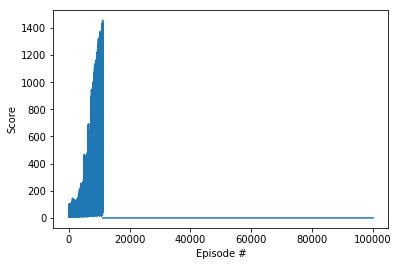

In [14]:
agent.load("weights\ppo_7250.pth")
agent.LR=5e-4
agent.GRADIENT_CLIP=5
agent.EPOCHS=8
agent.BATCH_SIZE=64
agent.GAMMA=0.99
agent.GAE_TAU=0.95
agent.CLIP_EPSILON=0.2
agent.C1 = 0.5
agent.C2 = 1
scores = train(agent, n_episodes=100000, max_t=1010, train_mode=True)
plot_result(scores)

In [ ]:
agent.load("weights\\96x96\\ppo_11100.pth")
agent.LR=1e-5
agent.GRADIENT_CLIP=5
agent.EPOCHS=4
agent.BATCH_SIZE=64
agent.GAMMA=0.99
agent.GAE_TAU=0.99
agent.CLIP_EPSILON=0.1
agent.C1 = 1
agent.C2 = 0.02
scores = train(agent, n_episodes=100000, max_t=1010, train_mode=True)
plot_result(scores)

Episode 50	Average Score: 875.844	Min Score: 38.779	Max Score: 1425.109
Episode 100	Average Score: 902.974	Min Score: 53.476	Max Score: 1434.880
Episode 150	Average Score: 784.089	Min Score: 45.584	Max Score: 1424.321
Episode 200	Average Score: 405.702	Min Score: 42.082	Max Score: 632.024
Episode 250	Average Score: 108.599	Min Score: 6.269	Max Score: 120.645
Episode 300	Average Score: 57.610	Min Score: 7.513	Max Score: 226.248
Episode 350	Average Score: 105.606	Min Score: 7.676	Max Score: 698.620
Episode 400	Average Score: 106.698	Min Score: 3.541	Max Score: 199.938
Episode 450	Average Score: 104.399	Min Score: 11.121	Max Score: 667.429
Episode 500	Average Score: 124.450	Min Score: 3.854	Max Score: 553.215
Episode 550	Average Score: 84.843	Min Score: 4.990	Max Score: 143.999
Episode 600	Average Score: 54.904	Min Score: 5.487	Max Score: 239.192
Episode 650	Average Score: 61.845	Min Score: 6.511	Max Score: 260.750
Episode 700	Average Score: 63.327	Min Score: 5.354	Max Score: 167.476
Epis

In [7]:
agent.load("weights\ppo_2750.pth")
agent.LR=1e-5
agent.GRADIENT_CLIP=5
agent.EPOCHS=8
agent.BATCH_SIZE=64
agent.GAMMA=0.99
agent.GAE_TAU=0.99
agent.CLIP_EPSILON=0.2
agent.C1 = 1
agent.C2 = 1
scores = train(agent, n_episodes=100000, max_t=1010, train_mode=True)
plot_result(scores)

RuntimeError: Error(s) in loading state_dict for Gaussian:
	Missing key(s) in state_dict: "actor.hidden_layers.0.weight", "actor.hidden_layers.0.bias", "actor.hidden_layers.1.weight", "actor.hidden_layers.1.bias", "actor.hidden_layers.2.weight", "actor.hidden_layers.2.bias". 
	Unexpected key(s) in state_dict: "actor1.hidden_layers.0.weight", "actor1.hidden_layers.0.bias", "actor1.hidden_layers.1.weight", "actor1.hidden_layers.1.bias", "actor1.hidden_layers.2.weight", "actor1.hidden_layers.2.bias". 

## Check the performance of the agent

In [ ]:
def check(agent, episode, train_mode=True):
    scores = []                        # list containing scores from each episode
    current_max = -1
    for i in range(episode):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        scores_one_episode = np.zeros(states.shape[0])
        max_reward = -100
        t = 0
        while True:
            t += 1
#         for t in range(max_t):
            actions, _, _ = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(np.clip(actions, -1, 1))[brain_name]   # send all actions to the environment
            next_states = env_info.vector_observations               # get next state (for each agent)
            rewards = env_info.rewards                               # get reward (for each agent)
            dones = env_info.local_done                              # see if episode finished
            scores_one_episode += env_info.rewards                   # update the score (for each agent)
            states = next_states                                     # roll over states to next time step
            max_reward = max(max_reward, np.max(rewards))
            if np.any(dones):                                        # exit loop if episode finished
                break
        current_max = max(current_max, t)
        print(str(current_max) + " " + str(max_reward))
        scores.append(np.average(scores_one_episode))
    return scores
agent.load("weights\\112x112(11)\\ppo_5500.pth")
scores = check(agent,10, False)
plot_result(scores)

102 3.030588388442993
778 3.5550386905670166
778 2.418546438217163


## View the trained agent
Use the cell below to load and view a trained agent

In [ ]:
def getRandomAgent():
    states = env_info.vector_observations
    action_size = brain.vector_action_space_size
    network = Gaussian(states.shape[1], action_size, activation=F.leaky_relu).to(device)
    agent = PPO(network, device,
                     LR=1e-5,
                     GRADIENT_CLIP=3, 
                     EPOCHS=6, 
                     BATCH_SIZE=128,
                    GAMMA=0.99,
                    GAE_TAU=0.99,
                    CLIP_EPSILON=0.1)
    agent.save("random.pth")
    return agent

In [ ]:
randomAgent = getRandomAgent()
for i in range(10):
    scores = validate(agent, 1000, False)
    print(np.mean(scores))

In [ ]:
agent.load("weights\ppo_2600.pth")
for i in range(1):
    scores = validate(agent, 1000, False)
    print(np.mean(scores))